# Grains, molecules, atoms

```
 +- grains
    +- grain_states [each line has a corresponding grain_XXXXX group]
    +- grain_0001
       +- molecule_states [each line has a corresponding molecule_XXXXX group]
       +- molecule_0001
          +- atom_states [one per line]
       +- molecule_0002
          +- atom_states
    +- grain_0002
       +- molecule_states
       +- molecule_0001
          +- atom_states 
```


In [37]:
%load_ext heat




The heat extension is already loaded. To reload it, use:
  %reload_ext heat


* dtype `a`: implies `'shape':'variable'` (`a3`, on the other hand, is fixed-size and does not imply variable length)
* dtype `l`: implies `'unit':'none'` (`none` unit is a shorthand for dimensionless unscaled)
* `'path'` creates iterator, `{ROW}` will expand to the row index of the parent struct
* all items must have `unit` (except of `path`, and cases where it is implied)
* item assignment must include units, and the value must be converted to the declared unit

There is 5 grains.
Grain <__main__.Hdf5DataProxy object at 0x7f7390614be0> has 35 molecules
Grain <__main__.Hdf5DataProxy object at 0x7f739060acd0> has 50 molecules
Grain <__main__.Hdf5DataProxy object at 0x7f738455e7f0> has 26 molecules
Grain <__main__.Hdf5DataProxy object at 0x7f7390695be0> has 46 molecules
Grain <__main__.Hdf5DataProxy object at 0x7f73ac14f520> has 36 molecules
2276 atoms created in 36.660603284835815 (62.083/sec).


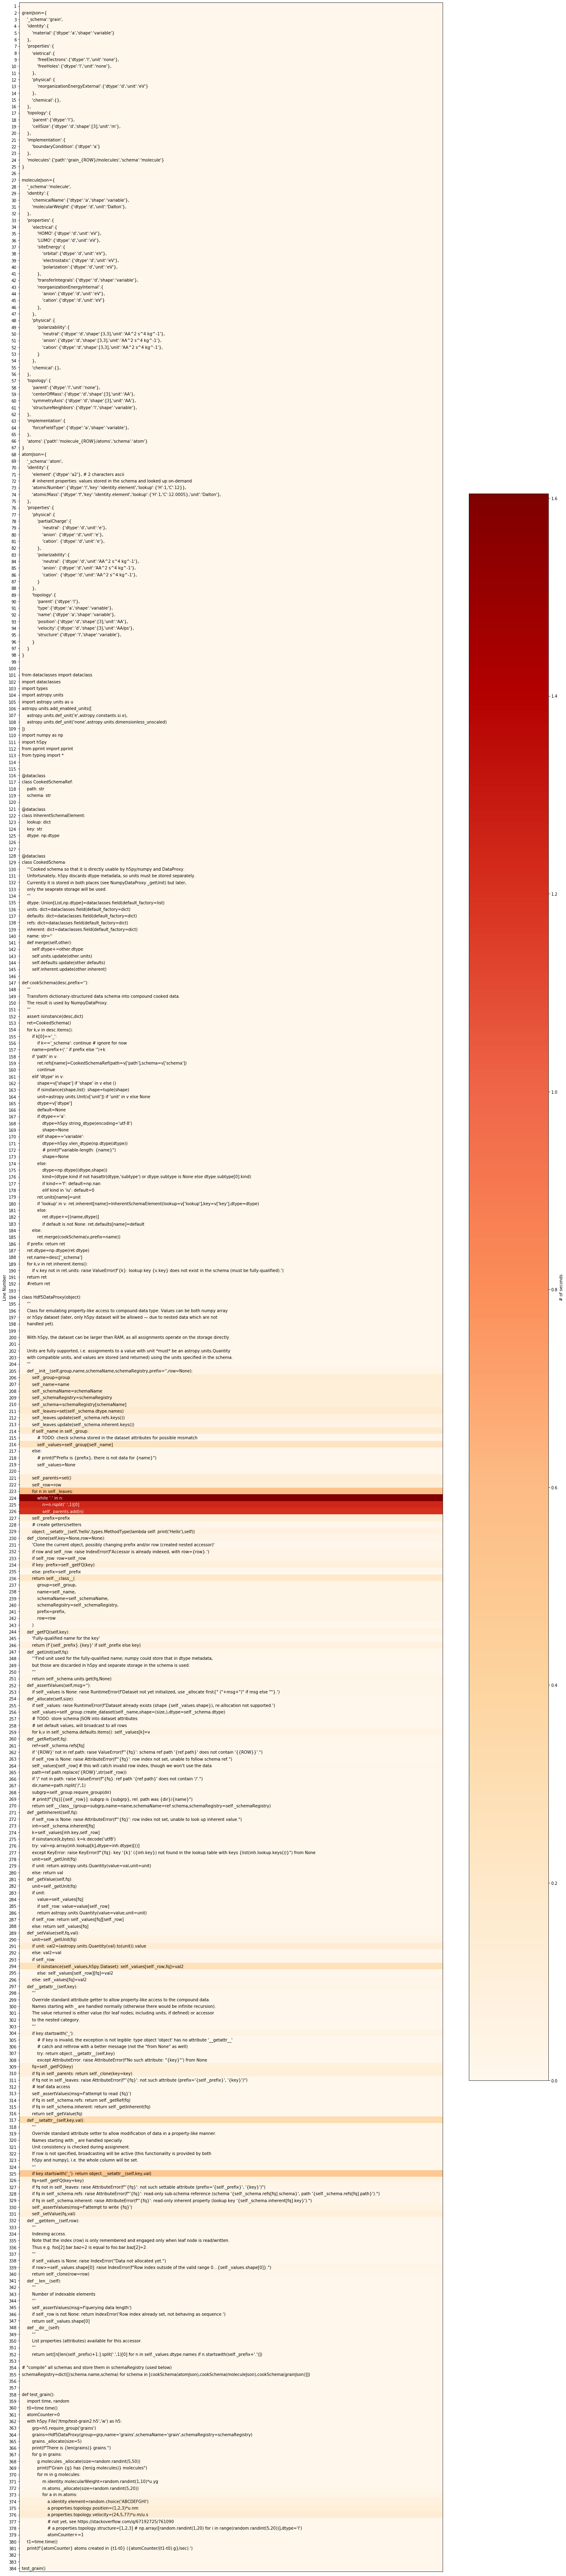

In [39]:
%%heat

grainJson={
    '_schema':'grain',
    'identity':{
        'material':{'dtype':'a','shape':'variable'}
    },
    'properties':{
        'eletrical':{
            'freeElectrons':{'dtype':'l','unit':'none'},
            'freeHoles':{'dtype':'l','unit':'none'},
        },
        'physical':{
            'reorganizationEnergyExternal':{'dtype':'d','unit':'eV'}
        },
        'chemical':{},
    },
    'topology':{
        'parent':{'dtype':'l'},
        'cellSize':{'dtype':'d','shape':[3],'unit':'m'},
    },
    'implementation':{
        'boundaryCondition':{'dtype':'a'}
    },
    'molecules':{'path':'grain_{ROW}/molecules','schema':'molecule'}
}

moleculeJson={
    '_schema':'molecule',
    'identity':{
        'chemicalName':{'dtype':'a','shape':'variable'},
        'molecularWeight':{'dtype':'d','unit':'Dalton'},
    },
    'properties':{
        'electrical':{
            'HOMO':{'dtype':'d','unit':'eV'},
            'LUMO':{'dtype':'d','unit':'eV'},
            'siteEnergy':{
                'orbital':{'dtype':'d','unit':'eV'},
                'electrostatic':{'dtype':'d','unit':'eV'},
                'polarization':{'dtype':'d','unit':'eV'},
            },
            'transferIntegrals':{'dtype':'d','shape':'variable'},
            'reorganizationEnergyInternal':{
                'anion':{'dtype':'d','unit':'eV'},
                'cation':{'dtype':'d','unit':'eV'}
            },
        },
        'physical':{
            'polarizability':{
                'neutral':{'dtype':'d','shape':[3,3],'unit':'AA^2 s^4 kg^-1'},
                'anion':{'dtype':'d','shape':[3,3],'unit':'AA^2 s^4 kg^-1'},
                'cation':{'dtype':'d','shape':[3,3],'unit':'AA^2 s^4 kg^-1'},
            }
        },
        'chemical':{},
    },
    'topology':{
        'parent':{'dtype':'l','unit':'none'},
        'centerOfMass':{'dtype':'d','shape':[3],'unit':'AA'},
        'symmetryAxis':{'dtype':'d','shape':[3],'unit':'AA'},
        'structureNeighbors':{'dtype':'l','shape':'variable'},
    },
    'implementation':{
        'forceFieldType':{'dtype':'a','shape':'variable'},
    },
    'atoms':{'path':'molecule_{ROW}/atoms','schema':'atom'}
}
atomJson={
    '_schema':'atom',
    'identity':{
        'element':{'dtype':'a2'}, # 2 characters ascii
        # inherent properties: values stored in the schema and looked up on-demand
        'atomicNumber':{'dtype':'l','key':'identity.element','lookup':{'H':1,'C':12}},
        'atomicMass':{'dtype':'f','key':'identity.element','lookup':{'H':1,'C':12.0005},'unit':'Dalton'},
    },
    'properties':{
        'physical':{
            'partialCharge':{
                'neutral': {'dtype':'d','unit':'e'},
                'anion': {'dtype':'d','unit':'e'},
                'cation': {'dtype':'d','unit':'e'},
            },
            'polarizability':{
                'neutral': {'dtype':'d','unit':'AA^2 s^4 kg^-1'},
                'anion': {'dtype':'d','unit':'AA^2 s^4 kg^-1'},
                'cation': {'dtype':'d','unit':'AA^2 s^4 kg^-1'},
            }
        },
        'topology':{
            'parent':{'dtype':'l'},
            'type':{'dtype':'a','shape':'variable'},
            'name':{'dtype':'a','shape':'variable'},
            'position':{'dtype':'d','shape':[3],'unit':'AA'},
            'velocity':{'dtype':'d','shape':[3],'unit':'AA/ps'},
            'structure':{'dtype':'l','shape':'variable'},
        }
    }
}


from dataclasses import dataclass
import dataclasses
import types
import astropy.units
import astropy.units as u
astropy.units.add_enabled_units([
    astropy.units.def_unit('e',astropy.constants.si.e),
    astropy.units.def_unit('none',astropy.units.dimensionless_unscaled)
])
import numpy as np
import h5py
from pprint import pprint
from typing import *

    
@dataclass
class CookedSchemaRef:
    path: str
    schema: str

@dataclass
class InherentSchemaElement:
    lookup: dict
    key: str
    dtype: np.dtype
    
    
@dataclass
class CookedSchema:
    '''Cooked schema so that it is directly usable by h5py/numpy and DataProxy.
    Unfortunately, h5py discards dtype metadata, so units must be stored separately.
    Currently it is stored in both places (see NumpyDataProxy._getUnit) but later,
    only the seaprate storage will be used.
    '''
    dtype: Union[List,np.dtype]=dataclasses.field(default_factory=list)
    units: dict=dataclasses.field(default_factory=dict)
    defaults: dict=dataclasses.field(default_factory=dict)
    refs: dict=dataclasses.field(default_factory=dict)
    inherent: dict=dataclasses.field(default_factory=dict)
    name: str=''
    def merge(self,other):
        self.dtype+=other.dtype
        self.units.update(other.units)
        self.defaults.update(other.defaults)
        self.inherent.update(other.inherent)

def cookSchema(desc,prefix=''):
    '''
    Transform dictionary-structured data schema into compound cooked data.
    The result is used by NumpyDataProxy.
    '''
    assert isinstance(desc,dict)
    ret=CookedSchema()
    for k,v in desc.items():
        if k[0]=='_':
            if k=='_schema': continue # ignore for now
        name=prefix+('.' if prefix else '')+k
        if 'path' in v:
            ret.refs[name]=CookedSchemaRef(path=v['path'],schema=v['schema'])
            continue
        elif 'dtype' in v:
            shape=v['shape'] if 'shape' in v else ()
            if isinstance(shape,list): shape=tuple(shape)
            unit=astropy.units.Unit(v['unit']) if 'unit' in v else None
            dtype=v['dtype']
            default=None
            if dtype=='a':
                dtype=h5py.string_dtype(encoding='utf-8')
                shape=None
            elif shape=='variable':
                dtype=h5py.vlen_dtype(np.dtype(dtype))
                # print(f"variable-length: {name}")
                shape=None
            else:
                dtype=np.dtype((dtype,shape))
                kind=(dtype.kind if not hasattr(dtype,'subtype') or dtype.subtype is None else dtype.subtype[0].kind)
                if kind=='f': default=np.nan
                elif kind in 'iu': default=0
            ret.units[name]=unit
            if 'lookup' in v: ret.inherent[name]=InherentSchemaElement(lookup=v['lookup'],key=v['key'],dtype=dtype)
            else:
                ret.dtype+=[(name,dtype)]
                if default is not None: ret.defaults[name]=default
        else:
            ret.merge(cookSchema(v,prefix=name))
    if prefix: return ret
    ret.dtype=np.dtype(ret.dtype)
    ret.name=desc['_schema']
    for k,v in ret.inherent.items():
        if v.key not in ret.units: raise ValueError(f'{k}: lookup key {v.key} does not exist in the schema (must be fully-qualified).')
    return ret
    #return ret

class Hdf5DataProxy(object):
    '''
    Class for emulating property-like access to compound data type. Values can be both numpy array
    or h5py dataset (later, only h5py dataset will be allowed — due to nested data which are not 
    handled yet).
    
    With h5py, the dataset can be larger than RAM, as all assignments operate on the storage directly.
    
    Units are fully supported, i.e. assignments to a value with unit *must* be an astropy.units.Quantity
    with compatible units, and values are stored (and returned) using the units specified in the schema.
    '''
    def __init__(self,group,name,schemaName,schemaRegistry,prefix='',row=None):
        self._group=group
        self._name=name
        self._schemaName=schemaName
        self._schemaRegistry=schemaRegistry
        self._schema=schemaRegistry[schemaName]
        self._leaves=set(self._schema.dtype.names)
        self._leaves.update(self._schema.refs.keys())
        self._leaves.update(self._schema.inherent.keys())
        if self._name in self._group:
            # TODO: check schema stored in the dataset attributes for possible mismatch
            self._values=self._group[self._name]
        else:
            # print(f"Prefix is {prefix}, there is not data for {name}")
            self._values=None
        
        self._parents=set()
        self._row=row
        for n in self._leaves:
            while '.' in n:
                n=n.rsplit('.',1)[0]
                self._parents.add(n)
        self._prefix=prefix
        # create getters/setters
        object.__setattr__(self,'hello',types.MethodType(lambda self: print('Hello'),self))
    def _clone(self,key=None,row=None):
        'Clone the current object, possibly changing prefix and/or row (created nested accessor)'
        if row and self._row: raise IndexError(f'Accessor is already indexed, with row={row}.')
        if self._row: row=self._row
        if key: prefix=self._getFQ(key)
        else: prefix=self._prefix
        return self.__class__(
            group=self._group,
            name=self._name,
            schemaName=self._schemaName,
            schemaRegistry=self._schemaRegistry,
            prefix=prefix,
            row=row
        )
    def _getFQ(self,key):
        'Fully-qualified name for the key'
        return (f'{self._prefix}.{key}' if self._prefix else key)
    def _getUnit(self,fq):
        '''Find unit used for the fully-qualified name; numpy could store that in dtype metadata,
        but those are discarded in h5py and separate storage in the schema is used.
        '''
        return self._schema.units.get(fq,None)
    def _assertValues(self,msg=''):
        if self._values is None: raise RuntimeError(f'Dataset not yet initialized, use _allocate first{" ("+msg+")" if msg else ""}.')
    def _allocate(self,size):
        if self._values: raise RuntimeError(f'Dataset already exists (shape {self._values.shape}), re-allocation not supported.')
        self._values=self._group.create_dataset(self._name,shape=(size,),dtype=self._schema.dtype)
        # TODO: store schema JSON into dataset attributes
        # set default values, will broadcast to all rows
        for k,v in self._schema.defaults.items(): self._values[k]=v
    def _getRef(self,fq):
        ref=self._schema.refs[fq]
        if '{ROW}' not in ref.path: raise ValueError(f"'{fq}': schema ref path '{ref.path}' does not contain '{{ROW}}'.")
        if self._row is None: raise AttributeError(f"'{fq}': row index not set, unable to follow schema ref.")
        self._values[self._row] # this will catch invalid row index, though we won't use the data
        path=ref.path.replace('{ROW}',str(self._row))
        if '/' not in path: raise ValueError(f"{fq}: ref path '{ref.path}' does not contain '/'.")
        dir,name=path.rsplit('/',1)
        subgrp=self._group.require_group(dir)
        # print(f"{fq}[{self._row}]: subgrp is {subgrp}, rel. path was {dir}/{name}")
        return self.__class__(group=subgrp,name=name,schemaName=ref.schema,schemaRegistry=self._schemaRegistry)
    def _getInherent(self,fq):
        if self._row is None: raise AttributeError(f"'{fq}': row index not set, unable to look up inherent value.")
        inh=self._schema.inherent[fq]
        k=self._values[inh.key,self._row]
        if isinstance(k,bytes): k=k.decode('utf8')
        try: val=np.array(inh.lookup[k],dtype=inh.dtype)[()]
        except KeyError: raise KeyError(f"{fq}: key '{k}' ({inh.key}) not found in the lookup table with keys {list(inh.lookup.keys())}") from None
        unit=self._getUnit(fq)
        if unit: return astropy.units.Quantity(value=val,unit=unit)
        else: return val
    def _getValue(self,fq):
        unit=self._getUnit(fq)
        if unit:
            value=self._values[fq]
            if self._row: value=value[self._row]
            return astropy.units.Quantity(value=value,unit=unit)
        if self._row: return self._values[fq][self._row]
        else: return self._values[fq] 
    def _setValue(self,fq,val):
        unit=self._getUnit(fq)
        if unit: val2=(astropy.units.Quantity(val).to(unit)).value
        else: val2=val
        if self._row:
            if isinstance(self._values,h5py.Dataset): self._values[self._row,fq]=val2
            else: self._values[self._row][fq]=val2
        else: self._values[fq]=val2
    def __getattr__(self,key):
        '''
        Override standard attribute getter to allow property-like access to the compound data.
        Names starting with _ are handled normally (otherwise there would be infinite recursion).
        The value returned is either value (for leaf nodes; including units, if defined) or accessor
        to the nested category.
        '''
        if key.startswith('_'):
            # if key is invalid, the exception is not legible: type object 'object' has no attribute '__getattr__'
            # catch and rethrow with a better message (not the "from None" as well)
            try: return object.__getattr__(self,key)
            except AttributeError: raise AttributeError(f'No such attribute: "{key}"') from None
        fq=self._getFQ(key)
        if fq in self._parents: return self._clone(key=key)
        if fq not in self._leaves: raise AttributeError(f"'{fq}': not such attribute (prefix='{self._prefix}', '{key}')")
        # leaf data access
        self._assertValues(msg=f'attempt to read {fq}')
        if fq in self._schema.refs: return self._getRef(fq)
        if fq in self._schema.inherent: return self._getInherent(fq)
        return self._getValue(fq)
    def __setattr__(self,key,val):
        '''
        Override standard attribute setter to allow modification of data in a property-like manner.
        Names starting with _ are handled specially.
        Unit consistency is checked during assignment.
        If row is not specified, broadcasting will be active (this functionality is provided by both
        h5py and numpy), i.e. the whole column will be set.
        '''
        if key.startswith('_'): return object.__setattr__(self,key,val)
        fq=self._getFQ(key=key)
        if fq not in self._leaves: raise AttributeError(f"'{fq}': not such settable attribute (prefix='{self._prefix}', '{key}')")
        if fq in self._schema.refs: raise AttributeError(f"'{fq}': read-only sub-schema reference (schema '{self._schema.refs[fq].schema}', path '{self._schema.refs[fq].path}').")    
        if fq in self._schema.inherent: raise AttributeError(f"'{fq}': read-only inherent property (lookup key '{self._schema.inherent[fq].key}').")    
        self._assertValues(msg=f'attempt to write {fq}')
        self._setValue(fq,val)
    def __getitem__(self,row): 
        '''
        Indexing access.
        Note that the index (row) is only remembered and engaged only when leaf node is read/written.
        Thus e.g. foo[2].bar.baz=2 is equal to foo.bar.baz[2]=2.
        '''
        if self._values is None: raise IndexError("Data not allocated yet.")
        if row>=self._values.shape[0]: raise IndexError(f"Row index outside of the valid range 0…{self._values.shape[0]}.")
        return self._clone(row=row)
    def __len__(self):
        '''
        Number of indexable elements
        '''
        self._assertValues(msg=f'querying data length')
        if self._row is not None: return IndexError('Row index already set, not behaving as sequence.')
        return self._values.shape[0]
    def __dir__(self):
        '''
        List properties (attributes) available for this accessor.
        '''
        return set([n[len(self._prefix)+1:].split('.',1)[0] for n in self._values.dtype.names if n.startswith(self._prefix+'.')])
        
# "compile" all schemas and store them in schemaRegistry (used below)
schemaRegistry=dict([(schema.name,schema) for schema in [cookSchema(atomJson),cookSchema(moleculeJson),cookSchema(grainJson)]])


def test_grain():
    import time, random
    t0=time.time()
    atomCounter=0
    with h5py.File('/tmp/test-grain2.h5','w') as h5:
        grp=h5.require_group('grains')
        grains=Hdf5DataProxy(group=grp,name='grains',schemaName='grain',schemaRegistry=schemaRegistry)
        grains._allocate(size=5)
        print(f"There is {len(grains)} grains.")
        for g in grains:
            g.molecules._allocate(size=random.randint(5,50))
            print(f"Grain {g} has {len(g.molecules)} molecules")
            for m in g.molecules:
                m.identity.molecularWeight=random.randint(1,10)*u.yg
                m.atoms._allocate(size=random.randint(5,20))
                for a in m.atoms:
                    a.identity.element=random.choice('ABCDEFGHI')
                    a.properties.topology.position=(1,2,3)*u.nm
                    a.properties.topology.velocity=(24,5,77)*u.m/u.s
                    # not yet, see https://stackoverflow.com/q/67192725/761090
                    # a.properties.topology.structure=[1,2,3] # np.array([random.randint(1,20) for i in range(random.randint(5,20))],dtype='l')
                    atomCounter+=1
    t1=time.time()
    print(f'{atomCounter} atoms created in {t1-t0} ({atomCounter/(t1-t0):g}/sec).')


test_grain()

In [27]:
with h5py.File('/tmp/test-atom.h5','w') as h5:
    atoms=Hdf5DataProxy(group=h5['/'],name='atomTest',schemaName='atom',schemaRegistry=schemaRegistry)
    atoms._allocate(size=10)
    # print(atoms.identity._prefix)
    # atoms.identity.element='C'
    print(atoms[0].properties.topology.position[1]) ## TODO
    atoms.hello()
    # print(atoms[0].properties.topology.position)
    # print(atoms.identity.atomicMass)

[0. 0. 0.] Angstrom
Hello


In [28]:
with h5py.File('/tmp/test-atom.h5','w') as h5:
    atoms=Hdf5DataProxy(group=h5['/'],name='atomTest',schemaName='atom',schemaRegistry=schemaRegistry)
    pprint(atoms)
    atoms._allocate(size=10)
    # atoms[3].identity.atomicMass
    atoms.identity.element='C'
    print(atoms.identity.element)
    print(atoms[1].identity.atomicNumber)
    print(atoms[3].identity.atomicMass)
    # atoms[2].identity.atomicNumber=33
    # atoms[0].getProperties().getTopology().setPosition((1,2,3)*u.nm)
    atoms[0].properties.topology.position=(1,2,3)*u.nm
    atoms[4].properties.topology.velocity=(24,5,77)*u.m/u.s
    print(atoms.properties.topology.position)
    print(atoms.properties.topology.velocity)
    print(dir(atoms.properties))
 
# test h5py
with h5py.File('/tmp/test-mol.h5','w') as h5:
    # grp=
    mols=Hdf5DataProxy(group=h5['/'],name='molTest',schemaName='molecule',schemaRegistry=schemaRegistry)
    pprint(mols)
    mols._allocate(size=10)
    mols.identity.molecularWeight=1*u.yg
    aa=mols[9].atoms
    aa._allocate(size=500)
    aa.properties.topology.position=(1,2,3)*u.nm
    aa.properties.topology.velocity=(24,5,77)*u.m/u.s
    print(mols.identity.molecularWeight)
    print(aa.properties.topology.position)
    print(aa.properties.topology.velocity)

[b'C' b'C' b'C' b'C' b'C' b'C' b'C' b'C' b'C' b'C']
12
12.000499725341797 u
[[10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]] Angstrom
[[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.24 0.05 0.77]
 [0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]] Angstrom / ps
['physical', 'topology']
[0.60221408 0.60221408 0.60221408 0.60221408 0.60221408 0.60221408
 0.60221408 0.60221408 0.60221408 0.60221408] u
[[10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]
 ...
 [10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]] Angstrom
[[0.24 0.05 0.77]
 [0.24 0.05 0.77]
 [0.24 0.05 0.77]
 ...
 [0.24 0.05 0.77]
 [0.24 0.05 0.77]
 [0.24 0.05 0.77]] Angstrom / ps


In [34]:
# test h5py


There is 5 grains.
Grain <__main__.Hdf5DataProxy object at 0x7f73905c1100> has 7 molecules
Grain <__main__.Hdf5DataProxy object at 0x7f73906ce790> has 14 molecules
Grain <__main__.Hdf5DataProxy object at 0x7f739060aa90> has 9 molecules
Grain <__main__.Hdf5DataProxy object at 0x7f73906e43a0> has 19 molecules
Grain <__main__.Hdf5DataProxy object at 0x7f73906f61c0> has 6 molecules
672 atoms created in 3.615095615386963 (185.887/sec).


Timer unit: 1e-06 s

Total time: 3.60685 s
File: <ipython-input-34-1c0749548e85>
Function: test_grain at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def test_grain():
     3         1          6.0      6.0      0.0      import time, random
     4         1          4.0      4.0      0.0      t0=time.time()
     5         1          1.0      1.0      0.0      atomCounter=0
     6         1        552.0    552.0      0.0      with h5py.File('/tmp/test-grain2.h5','w') as h5:
     7         1        115.0    115.0      0.0          grp=h5.require_group('grains')
     8         1         89.0     89.0      0.0          grains=Hdf5DataProxy(group=grp,name='grains',schemaName='grain',schemaRegistry=schemaRegistry)
     9         1       4202.0   4202.0      0.1          grains._allocate(size=5)
    10         1        124.0    124.0      0.0          print(f"There is {len(grains)} grains.")
    11         6       6682

In [107]:
if 0:
    with h5py.File('/tmp/test-vla.h5','w') as h5:
        dt=np.dtype([('a',h5py.vlen_dtype(np.dtype('int32')))])
        dset=h5.create_dataset('test',(5,),dtype=dt)
        dset['a'][2]=[1,2,3] # does not write the value back
        dset[2]['a']=[1,2,3] # does not write the value back
        dset['a',2]=[1,2,3]  # Cannot change data-type for object array
        dset[2,'a']=[1,2,3]  # Cannot change data-type for object array
        tmp=dset['a']; tmp[2]=[1,2,3]; dset['a']=tmp # Cannot change data-type for object array
        tmp=dset[2]; tmp['a']=[1,2,3]; dset[2]=tmp # 'list' object has no attribute 'dtype'



In [128]:
schemaRegistry['atom'].units

{'identity.element': None,
 'identity.atomicNumber': None,
 'identity.atomicMass': Unit("u"),
 'properties.physical.partialCharge.neutral': Unit("e"),
 'properties.physical.partialCharge.anion': Unit("e"),
 'properties.physical.partialCharge.cation': Unit("e"),
 'properties.physical.polarizability.neutral': Unit("Angstrom2 s4 / kg"),
 'properties.physical.polarizability.anion': Unit("Angstrom2 s4 / kg"),
 'properties.physical.polarizability.cation': Unit("Angstrom2 s4 / kg"),
 'properties.topology.parent': None,
 'properties.topology.type': None,
 'properties.topology.name': None,
 'properties.topology.position': Unit("Angstrom"),
 'properties.topology.velocity': Unit("Angstrom / ps"),
 'properties.topology.structure': None}